# CNN for Patient Monitor
---
to save model

In [2]:
# Introductory CNN Model: MNIST Digits
#---------------------------------------
#
# In this example, we will download the MNIST handwritten
# digits and create a simple CNN network to predict the
# digit category (0-9)

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
from tensorflow.python.framework import ops

import glob
import pandas as pd
from PIL import Image
import csv
import cv2
import random

ops.reset_default_graph()


ModuleNotFoundError: No module named 'PIL'

In [4]:
# Start a graph session
sess = tf.Session()

# Load data
data_dir = glob.glob('D:/Eun/CNN4PM/data/ML_Patient monitor data/RCM/PR/1/*.jpg')
data = []              # image dataset array
length = 0
for x in data_dir:
    data_img = Image.open(x)
    data.append(np.asarray(data_img, dtype="int32" ))

data = np.asarray(data,dtype="int32")
print(data[100].shape)

#data = np.expand_dims(data_temp, 0)
#data = np.array([np.reshape(length, (28,28)) for x in data_temp])
#print(type(data_temp.shape))


(28, 28)


In [25]:
label = pd.read_csv('D:/Eun/CNN4PM/data/ML_Patient monitor data/RCM_PR_1.CSV')
label['label'][14]

0

In [6]:
# Convert images into 28x28 (they are downloaded as 1x784)
train_xdata = np.array([np.reshape(x,(28,28)) for x in data])
#test_xdata = np.array([np.reshape(x, (28,28)) for x in mnist.test.images])


In [7]:
# Set model parameters
batch_size = 100
learning_rate = 0.005
evaluation_size = 500
image_width = 28
image_height = 28
target_size = max(label['label']) + 1
num_channels = 1 # greyscale = 1 channel
generations = 500
eval_every = 5
conv1_features = 25
conv2_features = 50
max_pool_size1 = 2 # NxN window for 1st max pool layer
max_pool_size2 = 2 # NxN window for 2nd max pool layer
fully_connected_size1 = 100

In [8]:
# Declare model placeholders
x_input_shape = (batch_size, image_width, image_height, num_channels)
x_input = tf.placeholder(tf.float32, shape=x_input_shape)
y_target = tf.placeholder(tf.int32, shape=(batch_size))

In [9]:
#eval_input_shape = (evaluation_size, image_width, image_height, num_channels)
#eval_input = tf.placeholder(tf.float32, shape=eval_input_shape)
#eval_target = tf.placeholder(tf.int32, shape=(evaluation_size))

In [10]:
# Declare model parameters
conv1_weight = tf.Variable(tf.truncated_normal([4, 4, num_channels, conv1_features],
                                               stddev=0.1, dtype=tf.float32),name = "conv1_weight")
conv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32),name = "conv1_bias")

conv2_weight = tf.Variable(tf.truncated_normal([4, 4, conv1_features, conv2_features],
                                               stddev=0.1, dtype=tf.float32),name = "conv2_weight")
conv2_bias = tf.Variable(tf.zeros([conv2_features], dtype=tf.float32),name = "conv2_bias")

In [11]:
# fully connected variables
resulting_width = image_width // (max_pool_size1 * max_pool_size2)
resulting_height = image_height // (max_pool_size1 * max_pool_size2)
full1_input_size = resulting_width * resulting_height * conv2_features

In [12]:
full1_weight = tf.Variable(tf.truncated_normal([full1_input_size, fully_connected_size1],
                          stddev=0.1, dtype=tf.float32), name = "full1_weight")
full1_bias = tf.Variable(tf.truncated_normal([fully_connected_size1], stddev=0.1, dtype=tf.float32), name = "full1_bias")
full2_weight = tf.Variable(tf.truncated_normal([fully_connected_size1, target_size],
                                               stddev=0.1, dtype=tf.float32), name = "full2_weight")
full2_bias = tf.Variable(tf.truncated_normal([target_size], stddev=0.1, dtype=tf.float32), name = "full2_bias")

In [13]:
# Initialize Model Operations
def my_conv_net(input_data):
    # First Conv-ReLU-MaxPool Layer
    conv1 = tf.nn.conv2d(input_data, conv1_weight, strides=[1, 1, 1, 1], padding='SAME',)
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
    max_pool1 = tf.nn.max_pool(relu1, ksize=[1, max_pool_size1, max_pool_size1, 1],
                               strides=[1, max_pool_size1, max_pool_size1, 1], padding='SAME')

    # Second Conv-ReLU-MaxPool Layer
    conv2 = tf.nn.conv2d(max_pool1, conv2_weight, strides=[1, 1, 1, 1], padding='SAME')
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_bias))
    max_pool2 = tf.nn.max_pool(relu2, ksize=[1, max_pool_size2, max_pool_size2, 1],
                               strides=[1, max_pool_size2, max_pool_size2, 1], padding='SAME')

    # Transform Output into a 1xN layer for next fully connected layer
    final_conv_shape = max_pool2.get_shape().as_list()
    final_shape = final_conv_shape[1] * final_conv_shape[2] * final_conv_shape[3]
    flat_output = tf.reshape(max_pool2, [final_conv_shape[0], final_shape])

    # First Fully Connected Layer
    fully_connected1 = tf.nn.relu(tf.add(tf.matmul(flat_output, full1_weight), full1_bias))

    # Second Fully Connected Layer
    final_model_output = tf.add(tf.matmul(fully_connected1, full2_weight), full2_bias)
    
    return(final_model_output)

In [14]:
model_output = my_conv_net(x_input)                # training

# Declare Loss Function (softmax cross entropy)
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_target, logits=model_output))


# Prediction Function
---
model output을 function의 input으로

In [15]:
# Create a prediction function
prediction = tf.nn.softmax(model_output,name = 'prediction')               #to training set


In [16]:
# Create accuracy function
def get_accuracy(logits, targets):
    batch_predictions = np.argmax(logits, axis=1)
    num_correct = np.sum(np.equal(batch_predictions, targets))
    return(100. * num_correct/batch_predictions.shape[0])


In [17]:
# Create an optimizer
my_optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9)
train_step = my_optimizer.minimize(loss)


# Initialize Variables
init = tf.global_variables_initializer()
sess.run(init)

In [18]:
# ========= Save models =============
saver = tf.train.Saver()


In [26]:
# Start training loop
train_loss = []
train_acc = []

for i in range(generations):
    rand_index = np.random.choice(len(data), size=batch_size)
    rand_x = data[rand_index]
    rand_x = np.expand_dims(rand_x, 3)
    rand_y = label['label'][rand_index]
    train_dict = {x_input: rand_x, y_target: rand_y}
    
    sess.run(train_step, feed_dict=train_dict)
    temp_train_loss, temp_train_preds = sess.run([loss, prediction], feed_dict=train_dict)    
    temp_train_acc = get_accuracy(temp_train_preds, rand_y)
       
    
    if (i+1) % eval_every == 0:
       
        # Record and print results
        train_loss.append(temp_train_loss)
        train_acc.append(temp_train_acc)
        acc_and_loss = [(i+1), temp_train_loss, temp_train_acc]
        acc_and_loss = [np.round(x,2) for x in acc_and_loss]
        print('Generation # {}. Train Loss: {:.2f}. Train Acc : {:.2f} '.format(*acc_and_loss))
        


        

Generation # 5. Train Loss: 2.28. Train Acc : 15.00 
Generation # 10. Train Loss: 2.26. Train Acc : 16.00 
Generation # 15. Train Loss: 2.28. Train Acc : 9.00 
Generation # 20. Train Loss: 2.29. Train Acc : 12.00 
Generation # 25. Train Loss: 2.28. Train Acc : 13.00 
Generation # 30. Train Loss: 2.29. Train Acc : 10.00 
Generation # 35. Train Loss: 2.27. Train Acc : 14.00 
Generation # 40. Train Loss: 2.24. Train Acc : 16.00 
Generation # 45. Train Loss: 2.26. Train Acc : 17.00 
Generation # 50. Train Loss: 2.25. Train Acc : 12.00 
Generation # 55. Train Loss: 2.27. Train Acc : 15.00 
Generation # 60. Train Loss: 2.27. Train Acc : 14.00 
Generation # 65. Train Loss: 2.27. Train Acc : 12.00 
Generation # 70. Train Loss: 2.28. Train Acc : 15.00 
Generation # 75. Train Loss: 2.27. Train Acc : 15.00 
Generation # 80. Train Loss: 2.28. Train Acc : 15.00 
Generation # 85. Train Loss: 2.26. Train Acc : 17.00 
Generation # 90. Train Loss: 2.29. Train Acc : 13.00 
Generation # 95. Train Loss: 2

In [27]:
saver.save(sess,"D:/Eun/CNN4PM/savedModel/1_CNN4PM.ckpt", global_step=499)
#saver.save(sess, "D:\Eun\CNN4PM\savedModel\training_model.ckpt", global_step=499)
print('Model saved in file')

Model saved in file


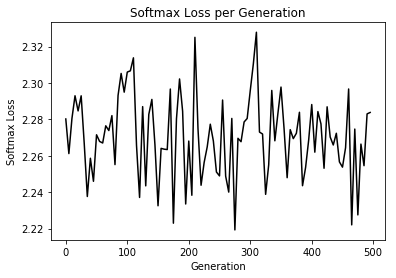

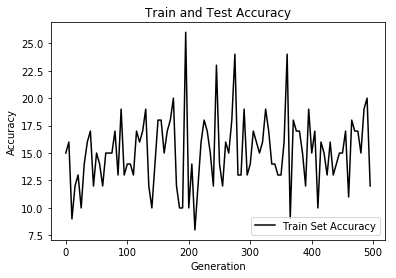

In [28]:
# Matlotlib code to plot the loss and accuracies
eval_indices = range(0, generations, eval_every)
# Plot loss over time
plt.plot(eval_indices, train_loss, 'k-')
plt.title('Softmax Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Softmax Loss')
plt.show()

# Plot train and test accuracy
plt.plot(eval_indices, train_acc, 'k-', label='Train Set Accuracy')
plt.title('Train and Test Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()


In [31]:
result = sess.run(prediction, feed_dict={x_input: np.reshape(train_xdata[:100],[100,28,28,1])})

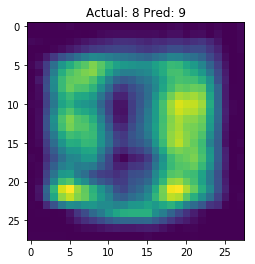

In [37]:


num=random.randrange(0,100)
plt.imshow(train_xdata[num])
plt.title('Actual: ' + str(label['label'][num]) + ' Pred: ' + str(np.argmax(result[num], axis=0)))
plt.show()